In [ ]:
# imoprt libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob 
import IPython
import IPython.display as ipd 

import librosa 
import librosa.display

In [85]:
# import labelencoder and scaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
encoder = LabelEncoder()
scaler = StandardScaler()

In [ ]:
df = pd.read_csv("extracted_features.csv")
# Afficher les premières lignes pour vérifier le contenu
print(df.head())
print(df.info())

# Séparer les variables explicatives (features) et la cible (genre)
# Ici, on retire les colonnes non numériques comme 'filename' si nécessaire
data = df.drop(columns=["filename", "genre"])  # ou adapter selon vos colonnes
labels = df["genre"]

# Encodage des labels (si ce sont des chaînes de caractères)
from sklearn.preprocessing import LabelEncoder, StandardScaler
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Standardisation des features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Séparation des données d'entraînement et de test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_scaled, labels_encoded, test_size=0.2, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


   length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  661794          0.417180         0.083849  0.115737  0.002511   
1  661504          0.429750         0.078049  0.100293  0.001004   
2  661504          0.452995         0.086779  0.084745  0.001776   
3  661794          0.450119         0.079885  0.169938  0.004638   
4  661504          0.434904         0.079379  0.114454  0.001662   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             3256.824592          388583.502328              2898.247907   
1             2128.932662          326430.225668              2108.898696   
2             2292.343238          429166.827516              2348.257608   
3             3167.957020          670882.410426              3047.751585   
4             1974.507687          351058.059434              2089.631458   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc17_mean  mfcc17_var  \
0            93275.687116   6681.488136  ...    -4.3770

In [91]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
    
# create an instance of each classification algorithm
g=GaussianNB()
b=BernoulliNB()
KN=KNeighborsClassifier()
D=DecisionTreeClassifier()
XGB=XGBClassifier()

algos=[g,b,KN,D,XGB]
algo_names=['GaussianNB','BernoulliNB','KNeighborsClassifier','DecisionTreeClassifier','XGBClassifier']
   
accuracy_scored=[]
    
# fit and predict for each Algo
for item in algos:
    item.fit(x_train,y_train)
    item.predict(x_test)
    accuracy_scored.append(accuracy_score(y_test,item.predict(x_test)))

In [92]:
# show results in a DataFrame
result = pd.DataFrame(accuracy_scored, columns=["Accuracy"])
result['Algos']=algo_names
result.sort_values('Accuracy',ascending=False)

,Accuracy,Algos
4,0.840,XGBClassifier
2,0.730,KNeighborsClassifier
0,0.590,GaussianNB
3,0.580,DecisionTreeClassifier
1,0.555,BernoulliNB


In [93]:
# import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

In [94]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = keras.models.Sequential([
    Dense(256, activation="relu", kernel_regularizer=l2(0.001), input_shape=(x_train.shape[1],)),
    BatchNormalization(),  # Normalize activations
    Dropout(0.3),  # Increase dropout to 30%

    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation="softmax")  # Keep softmax for multi-class classification
])

# Compile with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)



# Add Early Stopping & Learning Rate Reduction
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8)

# Train the model with callbacks



In [95]:
print(model.summary()) # show summary of model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               15104     
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

In [96]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               15104     
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

In [97]:
# Entraînement du modèle
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test),
                    batch_size=128, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
7/7 [==============================] - 1s 35ms/step - loss: 3.4538 - accuracy: 0.1039 - val_loss: 2.6043 - val_accuracy: 0.2200
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 3.0058 - accuracy: 0.1665 - val_loss: 2.5068 - val_accuracy: 0.2600
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 2.7554 - accuracy: 0.2228 - val_loss: 2.4233 - val_accuracy: 0.4050
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 2.5389 - accuracy: 0.3016 - val_loss: 2.3421 - val_accuracy: 0.4750
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 2.3796 - accuracy: 0.3154 - val_loss: 2.2583 - val_accuracy: 0.5250
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 2.3170 - accuracy: 0.3367 - val_loss: 2.1786 - val_accuracy: 0.5300
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 2.2450 - accuracy: 0.3680 - val_loss: 2.0948 - val_accuracy: 0.5250
Epoch 8/100
7/7 [=========

In [98]:
# Évaluation du modèle
loss, accuracy = model.evaluate(x_test, y_test, batch_size=128)
print("Précision :", accuracy)

2/2 [==============================] - 0s 3ms/step - loss: 0.9946 - accuracy: 0.7950
Précision : 0.7950000166893005


In [99]:
print("Accuracy:",accuracy) # print accuracy

Accuracy: 0.7950000166893005


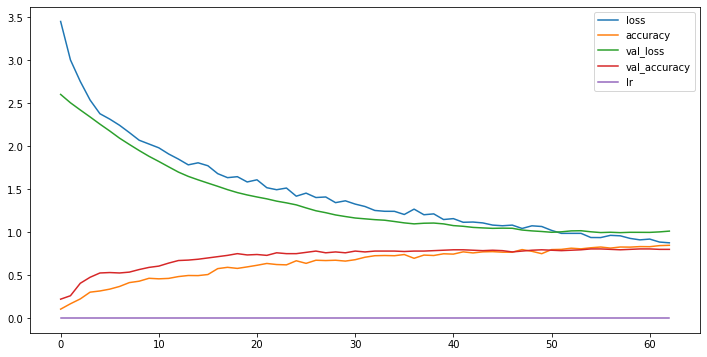

In [100]:
# Plot results
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

In [67]:
import joblib

# Save the trained XGB model
joblib.dump(XGB, "xgb_model5.pkl")

['xgb_model5.pkl']

In [34]:
!pip show xgboost

Name: xgboost
Version: 1.6.2
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy, scipy
Required-by: TPOT


In [1]:
!pip show librosa

Name: librosa
Version: 0.9.2
Summary: Python module for audio and music processing
Home-page: https://librosa.org
Author: Brian McFee, librosa development team
Author-email: brian.mcfee@nyu.edu
License: ISC
Location: /opt/conda/lib/python3.7/site-packages
Requires: audioread, decorator, joblib, numba, numpy, packaging, pooch, resampy, scikit-learn, scipy, soundfile
Required-by: 


TEST
